# Part 1: Simple Gaussian Model with BBVI

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Generate data from a simple model: Normal(10, 1)
data = np.random.normal(loc = 10, scale = 1, size = 100)

## Model specification


<img src="./mean_model.png" width="600">

## Manual estimation of the gradient of the ELBO for the above model

In [ ]:
# Gradient estimator using sampling -- vanilla BBVI
# We here assume the model X ~ Normal(mu, 1)
# with unknown mu, that in itself is Normal, mean 0 and standard deviation 1000, 
# so effectively an uniformed prior. 
# The variational dstribution for mu is also Normal, with parameter q_mu_lambda
# -- taking the role of lambda in the calculations -- and variance 1.

def grad_estimate(q_mu_lambda, samples = 1):
    # sum_grad_estimate will hold the sum as we move along over the <samples> samples. 
    sum_grad_estimate = 0
    for i in range(samples):
        # Sample one example from current best guess for the variational distribution
        mu_sample = np.random.normal(loc=q_mu_lambda, scale=1, size=1)
        
        # Now we want to calculate the contribution from this sample, namely 
        # [log p(x, mu_sample) - log q(mu|lambda) ] * grad( log q(mu_sample|lambda) )
        #
        # First log p(x|mu_sample) + log p(mu_sample) - log q(mu_sample|lambda) 
        value = np.sum(norm.logpdf(data, loc=mu_sample, scale=1)) 
        + norm.logpdf(mu_sample, loc = 0, scale = 1000)  
        - norm.logpdf(mu_sample, loc= q_mu_lambda, scale = 1)
        
        # Next grad (log q(mu_sample|lambda))
        # The Normal distribution gives the score function with known variance as <value> - <mean>
        grad_q = mu_sample - q_mu_lambda
        
        # grad ELBO for this sample is therefore in total given by
        sum_grad_estimate = sum_grad_estimate + grad_q * value
        
    # Divide by number of samples to get average value -- the estimated expectation  
    return sum_grad_estimate/samples

## Checking the variation in gradient estimate

In [ ]:
# To check the variation / "unreliability" of the gradient estimate we repeat 
# several times for the same lambda value and notice difference

# Location to check -- close to the data mean (at +10). 
# The prior will move the variational optimium **slightly** away from the data mean, 
# but due to the large prior variance of mu this should be a very limited effect.
# We should therefore expect a positive derivative (since we want to move 
# q_mu_lambda towards the data mean, that is, **increase** it)
q_mu_lambda = 9

plt.figure(figsize=(8,6))
sns.set()
grad_est = {}
# Do with different sample sizes
for sample_count in [1, 2, 3, 4, 5, 10, 25]:

    #loop
    q_grad = []
    for t in range(500):
        q_grad.append(grad_estimate(q_mu_lambda, samples=sample_count)[0])
 
    grad_est["$M = {:d}$".format(sample_count)] = q_grad
    
    # Report back
    print("M = {:2d} sample(s) in BBVI -- Mean of gradient: {:7.3f}; Std.dev. of gradient: {:7.3f}".format(
        sample_count, np.mean(q_grad), np.std(q_grad)))

df = pd.DataFrame(grad_est)
sns.kdeplot(data=df)    
plt.xlim([-500, 500])
plt.show()      

## Exercise

* What can we say about the gradient estimate based on the plots above?
* Implement and test your own gradient ascent learning algorithm starting from, say, q_mu_lambda=-10. Experiment with different learning rates, number of samples used for the gradient estimate, possibly supplemented with momentum.
* Optional: Adapt the implementation above so that we can also learn the variance of the q distribution 

# Part 2: Thumb tack

In [3]:
import pyro
import torch
from pyro.optim import SGD, Adam
import pyro.distributions as dist
from torch.distributions import constraints
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
%matplotlib inline
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Model
We consider the thumb tack model (to see the figures you should be logged in to Moodle):

<img src="./thumb_tack.png" width="600">

Recall the beta distribution 

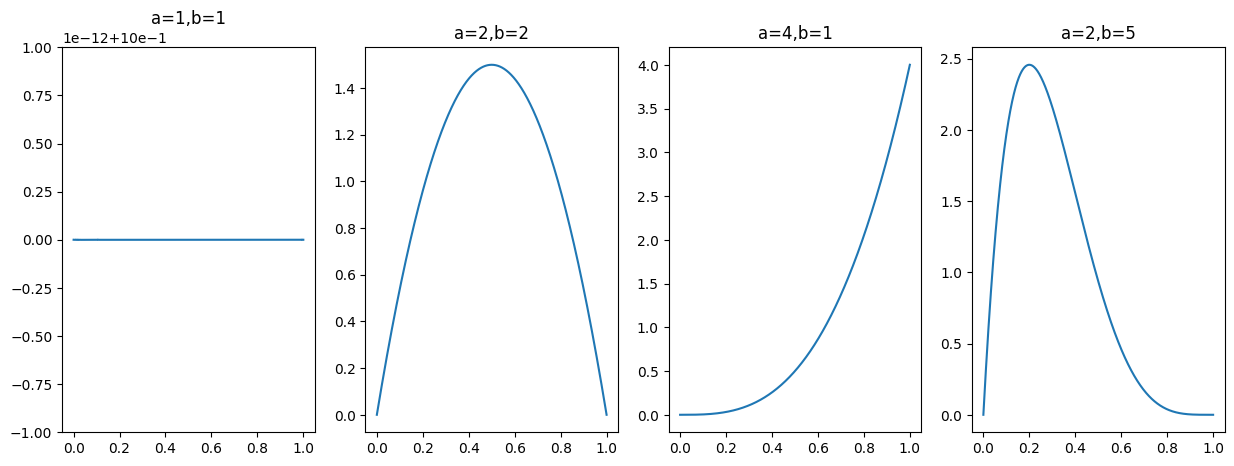

In [5]:
parameters = [(1,1), (2,2), (4,1),(2,5)]
x = np.linspace(0,1,1000)
plt.figure(figsize=(15, 5))
for idx, para in enumerate(parameters):
    plt.subplot(1, len(parameters), idx+1)
    y = beta.pdf(x, *para)
    plt.title(f'a={para[0]},b={para[1]}')
    plt.plot(x,y)

## The model

Here we define the probabilistic model. Notice the close resemblance with the plate specification above.

In [6]:
# Defines the thumb_tack model. The 'data' is a 0-1 tensor of type float  
def thumb_tack_model(data):  
    
    # Define the random variable theta
    theta = pyro.sample("theta", dist.Beta(2.0,5.0))
    
    # and now the plate holding the observations. The number of observations are determined by the data set 
    # supplied to the function
    with pyro.plate("thumb_tack_plate"):
        pyro.sample(f"obs", dist.Bernoulli(probs=theta), obs=data)

## The variational distribution

In Pyro the variational distribution is defined as a so-called guide. In this example our variational distribution is a beta distribution with parameters q_alpha and q_beta:

$$
q(\theta)= \mathit{Beta}(\theta | \alpha, \beta)
$$

In [7]:
def thumb_tack_guide(data):

    # We initialize the variational parameters q_alpha and q_beta to 1.0. Also, we constrain the parameters to be positive as per 
    # definition of the distribution
    q_alpha = pyro.param("q_alpha", torch.tensor(1.0), constraint=constraints.positive)
    q_beta = pyro.param("q_beta", torch.tensor(1.0), constraint=constraints.positive)

    # The name of the random variable of the variational distribution must match the name of the corresponding
    # variable in the model exactly.
    pyro.sample("theta", dist.Beta(q_alpha, q_beta))

## Learning

For optimizing the ELBO we rely on a standard stochastic gradient descent

In [9]:
def thumb_tack_learn(data, num_iter=5000):

    pyro.clear_param_store()

    # Define the ELBO and the optimization function
    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model=thumb_tack_model,
                         guide=thumb_tack_guide,
                         optim=SGD({'lr':0.001}),
                         loss=elbo)

    # Perform a fixed number of gradient steps
    num_steps = num_iter
    for step in range(num_steps):
        loss = svi.step(data)

        if step % 100 == 0:
            print(f"Loss for iteration {step}: {loss}")

## Analyze

Let's take a look at the learned variational distribution 

In [10]:
def thumb_tack_analyze(data):

    # Get the values of the variational parameters
    q_alpha = pyro.param("q_alpha").item()
    q_beta = pyro.param("q_beta").item()

    mean = q_alpha/(q_alpha + q_beta)
    std = q_alpha*q_beta/(((q_alpha+q_beta)**2)*(q_alpha + q_beta + 1.0))

    print(f"Mean: {mean}")
    print(f"Standard deviation: {std}")

    x = np.linspace(0.0, 1.0, 1000)
    plt.plot(x, beta.pdf(x, q_alpha, q_beta), label='Variational dist.')
    plt.plot(x,beta.pdf(x, data[data==1].shape[0]+1,data[data==0].shape[0]+1), label='True dist.')
    plt.legend()

## Perform experiments

In [11]:
# The data consists of 20 pin ups ('1') and 80 pin down ('0'). Squeeze is just used to compress the dimensions 
# from 2 to 1
data = torch.cat((torch.ones(20, 1), torch.zeros(80, 1))).squeeze()

# Do learning
thumb_tack_learn(data, num_iter=1000)

Loss for iteration 0: 49.51806306838989
Loss for iteration 100: 54.16282618045807
Loss for iteration 200: 54.747965812683105
Loss for iteration 300: 51.294530391693115
Loss for iteration 400: 55.88097286224365
Loss for iteration 500: 52.80346179008484
Loss for iteration 600: 50.649248123168945
Loss for iteration 700: 55.089659690856934
Loss for iteration 800: 57.77809119224548
Loss for iteration 900: 52.65845251083374


## Show the results

Mean: 0.2012178682927857
Standard deviation: 0.005513796864363256


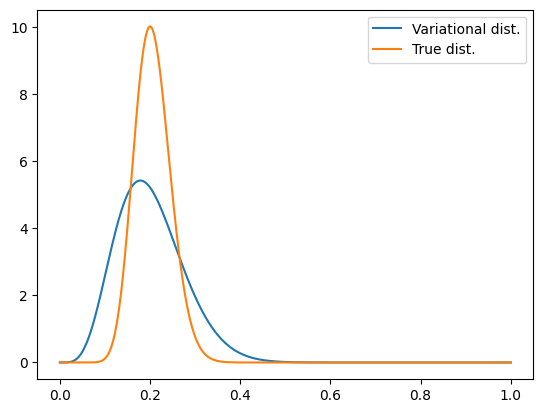

In [12]:
thumb_tack_analyze(data)

# Part 3: Exercise

## Introduction

In this exercise we will play around with the same model as in Part 1, where we derived the required gradients manually. Here we instead rely on differentiation functionality in Pyro, which, in turn is based n PyTorch.

## The model in plate notation

<img src="./mean_model.png" width="600">

## The model defined in Pyro

Here we define the probabilistic model. Notice the close resemblance with the plate specification above.

In [33]:
def mean_model(data):

    # Define the random variable mu having a noral distribution as prior
    mu = pyro.sample("mu", dist.Normal(0.0,1000.0))

    # and now the plate holding the observations. The number of observations are determined by the data set 
    # supplied to the function. 
    with pyro.plate("x_plate"):
        pyro.sample("x", dist.Normal(mu, 1), obs=data)

## The variational distribution

In Pyro the variational distribution is defined as a so-called guide. In this example our variational distribution is a beta distribution with parameters q_alpha and q_beta:

$$
q(\mu)= \mathit{Normal}(\mu | q_{mu}, 1)
$$

In [39]:
def mean_guide(data):
    # We initialize the variational parameter to 0.0. 
    q_mu = pyro.param("q_mu", torch.tensor(0.0))
    q_std = pyro.param("q_std", torch.tensor(1.0), constraint=constraints.positive)

    # The name of the random variable of the variational distribution must match the name of the corresponding
    # variable in the model exactly.
    pyro.sample("mu", dist.Normal(q_mu, q_std))

## Learning

Here we encapsulate the learning steps, relying on standard stochastic gradient descent

In [40]:
def learn(data):

    pyro.clear_param_store()

    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model=mean_model,
                         guide=mean_guide,
                         optim=SGD({'lr':0.0001}),
                         loss=elbo)

    num_steps = 1000
    for step in range(num_steps):
        loss = svi.step(data)

        if step % 50 == 0:
            print(f"Loss for iteration {step}: {loss}")

In [41]:
data = torch.tensor(np.random.normal(loc=10.0, scale=1.0, size=100),dtype=torch.float)
learn(data)

Loss for iteration 0: 5528.4164073467255
Loss for iteration 50: 2058.343059003353
Loss for iteration 100: 1033.0566014051437
Loss for iteration 150: 378.35159063339233
Loss for iteration 200: 245.461365878582
Loss for iteration 250: 163.3805626630783
Loss for iteration 300: 163.3822671175003
Loss for iteration 350: 173.43769693374634
Loss for iteration 400: 152.44228839874268
Loss for iteration 450: 157.33560901880264
Loss for iteration 500: 161.41063904762268
Loss for iteration 550: 154.0872198343277
Loss for iteration 600: 152.58686208724976
Loss for iteration 650: 152.97901606559753
Loss for iteration 700: 152.6536327600479
Loss for iteration 750: 152.90974724292755
Loss for iteration 800: 155.8330864906311
Loss for iteration 850: 152.75869047641754
Loss for iteration 900: 153.20099461078644
Loss for iteration 950: 153.36249327659607


Get the learned variational parameter

In [43]:
qmu = pyro.param("q_mu").item()
qstd = pyro.param("q_std").item()

In [44]:
print(f"Mean of variational distribution: {qmu}")
print(f"Standard deviation of variational distribution: {qstd}")

Mean of variational distribution: 10.045190811157227
Standard deviation of variational distribution: 0.21900804340839386


## Exercise
* Adapt the code above to accomodate a slight more rich variational distribution, where we also have a variational parameter for the standard deviation:
$$
q(\mu)= \mathit{Normal}(\mu | q_{mu}, q_{std})
$$
* Experiment with different data sets and parameter values. Try visualizing the variational posterior distribution.

# Part 4: Self study

In this self study you will explore Pyro a bit further, but as opposed to the last self study session where focus was on modeling we will here take a slightly closer lool at (variational) inference in Pyro. 

Before starting on the self study, consider revisiting the Pyro documentation listed under reading material for the last two lectures:
* http://pyro.ai/examples/intro_long.html
* http://pyro.ai/examples/bayesian_regression.html
* http://pyro.ai/examples/svi_part_i.html

Afterwards, continue with the notebook below, where we consider (Bayesian) linear regression using Pyro based on the same setup as in the lecture. 

In [13]:
import pyro
import torch
import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
import numpy as np


### Generate data
This data generation is similar to what was done during the lecture; we have one predictor variable 'x' and one response variable 'y', but here collected in a  dictionary.

In [14]:
def generate_data(N=10, true_w0= 1., true_w1=.5):
    gamma = 4.  # The *precision* in the observation noise
    st_dev = 1. / np.sqrt(gamma)  # And corresponding standard deviation
    np.random.seed(123)
    x = 5 * np.random.rand(N)  # The x-points are sampled uniformly on [0, 5]
    y = np.random.normal(loc=true_w0 + true_w1 * x, scale=st_dev)  # And the response is sampled from the Normal
    return {"x": torch.tensor(x, dtype=torch.float), "y": torch.tensor(y, dtype=torch.float)}

Helper function for visualizing the data as well as the true and learned functions

In [15]:
def data_plotter(data, true_w0=None, true_w1=None,
                 approx_w0=None, approx_w1=None):
    """
    Use to plot data. If y is not none it contains responses, and (x,y) will be scatter-plotted
    If neither true_w0 nor true_w1 is None, we will plot the line true_w0 + x * true_w1 in red.
    If neither approx_w0 nor approx_w1 is None, we plot the line approx_w0 + x * approx_w1 in green.
    """
    if data is not None:
        plt.plot(data["x"].numpy(), data["y"].numpy(), "bo")

    # Plot true line if given
    if true_w0 is not None and true_w1 is not None:
        plt.plot(data["x"].numpy(), true_w0 + true_w1 * data["x"].numpy(), "r-")

    # Plot approximation if given
    if approx_w0 is not None and approx_w1 is not None:
        plt.plot(data["x"].numpy(), approx_w0+ approx_w1* data["x"].numpy(), "g-", alpha=.2)


Generate a data set with 50 data points

In [46]:
true_w0= 1.
true_w1=.5
data = generate_data(N=10, true_w0=true_w0, true_w1=true_w1)

Plot the data together with the regression line around which the data has been generated.

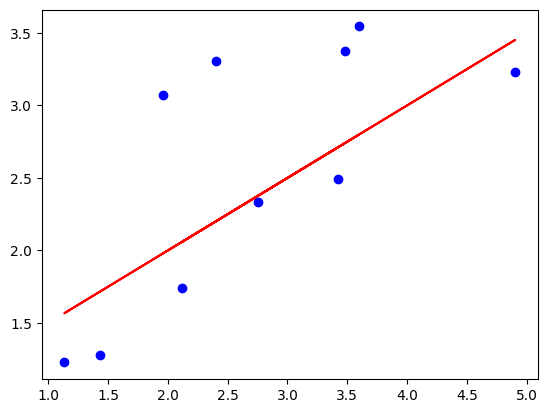

In [47]:
data_plotter(data, true_w0=true_w0, true_w1=true_w1)

## Specification of the Pyro model and guide

Here we specify a (Bayesian) linear regression model in Pyro. The 'data' argument is a dictionary covering the data of the predictor and response variable

In [48]:
def lin_reg_model(data):

    w0 = pyro.sample("w0", dist.Normal(0.0, 1000.0))
    w1 = pyro.sample("w1", dist.Normal(0.0, 1000.0))

    with pyro.plate("data_plate"):
        pyro.sample("y", dist.Normal(data["x"] * w1 + w0, 1.0), obs=data["y"])

Here we specify the variational distribution, which is called a guide in Pyro. We make the mean field assumption and assume that the variational distribution factorizes wrt. to 'w0' and 'w1'.

In [131]:
def lin_reg_guide(data):
    w0_mean = pyro.param("w0_mean", torch.tensor(20.0))
    w0_scale = pyro.param("w0_scale", torch.tensor(5.0), constraint=constraints.positive)
    pyro.sample("w0", dist.Normal(w0_mean, w0_scale))
    
    w1_mean = pyro.param("w1_mean", torch.tensor(5.0))
    w1_scale = pyro.param("w1_scale", torch.tensor(10.0), constraint=constraints.positive)
    pyro.sample("w1", dist.Normal(w1_mean, w1_scale))

### Learning

In this function the actual learning is taking place. Notice that the structure is similar to what we saw in the example notebooks during the lecture.

In [132]:
def learn(N=10, data=None, lr=0.0001, guide=lin_reg_guide):
    if data is None:
        data = generate_data(N=N)

    pyro.clear_param_store()

    elbo = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model=lin_reg_model,
                         guide=lin_reg_guide,
                         optim=SGD({"lr": lr}),
                         loss=elbo)

    num_steps = 5000
    for step in range(num_steps):
        loss = svi.step(data)

        if step % 100 == 0:
            w0_mean = pyro.param("w0_mean").detach().item()
            w0_scale = pyro.param("w0_scale").detach().item()
            w1_mean = pyro.param("w1_mean").detach().item()
            w1_scale = pyro.param("w1_scale").detach().item()
            print(f"Loss (iter: {step}): {loss}")
            print(f"w0: {w0_mean} +/- {w0_scale}\t \t w1: {w1_mean} +/- {w1_scale}")

In [84]:
learn(data=data)

Loss (iter: 0): 161.149787068367
w0: -0.004690644331276417 +/- 1.0020947456359863	 	 w1: -0.015449363738298416 +/- 0.9574512243270874
Loss (iter: 100): 30.44856035709381
w0: 0.192385733127594 +/- 0.9229192733764648	 	 w1: 0.5669549107551575 +/- 0.5302352905273438
Loss (iter: 200): 26.108732163906097
w0: 0.2449551373720169 +/- 0.870507001876831	 	 w1: 0.6974277496337891 +/- 0.44126924872398376
Loss (iter: 300): 26.95932787656784
w0: 0.2730806767940521 +/- 0.8063556551933289	 	 w1: 0.7516510486602783 +/- 0.38177579641342163
Loss (iter: 400): 29.310966908931732
w0: 0.29530709981918335 +/- 0.769414484500885	 	 w1: 0.7916271686553955 +/- 0.3392498791217804
Loss (iter: 500): 27.578482449054718
w0: 0.2920948266983032 +/- 0.7237269878387451	 	 w1: 0.754244327545166 +/- 0.3113953173160553
Loss (iter: 600): 26.707443058490753
w0: 0.32275390625 +/- 0.6867006421089172	 	 w1: 0.8162841200828552 +/- 0.29345229268074036
Loss (iter: 700): 27.794184982776642
w0: 0.32199496030807495 +/- 0.65740042924880

### Analyze the results

Here we sample weights from the posterior distributions over 'w0' and 'w1'. The distribution of the generated weights (and the corresponding models) illustrates how confident we are in the model, an insight you cannot get when only having point estimates of the model parameters as found with, e.g., maximum likelihood learning. 

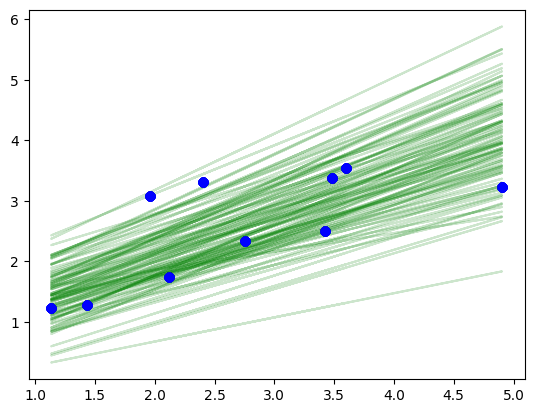

In [86]:
for _ in range(100):
    w0_mean = pyro.param("w0_mean").detach().item()
    w0_scale = pyro.param("w0_scale").detach().item()
    w1_mean = pyro.param("w1_mean").detach().item()
    w1_scale = pyro.param("w1_scale").detach().item()
    w0_sample = pyro.sample("w0_sample", dist.Normal(w0_mean, w0_scale)).numpy()
    w1_sample = pyro.sample("w1_sample", dist.Normal(w1_mean, w1_scale)).numpy()
    data_plotter(data, approx_w0=w0_sample, approx_w1=w1_sample)
data_plotter(data)
plt.show()

## Exercises:
* Generate data sets of varying sizes and characteristics (by changing the parameters in the 'generate_data' function) and investigate and compare the resulting models.
* Analyze how learning is affected by changing the learning rate and the initial values of the parameters specified in the guide function.
* Experiment with different types of prior knowledge in the model specification (e.g. change the mean and scale of the distributions over the weights). For instance, we may (mostly likely erroneously considering the data) have a prior expectation that 'w0' is around 5.0, and we can encode the strength of this belief through the scale of the corresponding distribution. 

### Generate datasets of varying and chasteristics and investigate the results

In [76]:
new_data = generate_data(N=100, true_w0=1.0, true_w1=0.5) # First generating larger dataset
learn(data=new_data)

Loss (iter: 0): 1273.141459107399
w0: 0.04640062898397446 +/- 0.9557779431343079	 	 w1: 0.13181248307228088 +/- 0.9295201301574707
Loss (iter: 100): 132.05233824253082
w0: 0.31668621301651 +/- 0.6024990677833557	 	 w1: 0.5288058519363403 +/- 0.23256605863571167
Loss (iter: 200): 181.80953311920166
w0: 0.480191707611084 +/- 0.4358868896961212	 	 w1: 0.6797027587890625 +/- 0.1730821281671524
Loss (iter: 300): 129.12533581256866
w0: 0.5893080830574036 +/- 0.3833107650279999	 	 w1: 0.6552913188934326 +/- 0.147569477558136
Loss (iter: 400): 171.76582604646683
w0: 0.6425015926361084 +/- 0.33302974700927734	 	 w1: 0.5786029100418091 +/- 0.12991905212402344
Loss (iter: 500): 147.4090495109558
w0: 0.7346758246421814 +/- 0.30690714716911316	 	 w1: 0.6040701866149902 +/- 0.11131822317838669
Loss (iter: 600): 129.39540016651154
w0: 0.7889299392700195 +/- 0.29111871123313904	 	 w1: 0.5644403100013733 +/- 0.10477196425199509
Loss (iter: 700): 124.622967004776
w0: 0.8390463590621948 +/- 0.27394825220

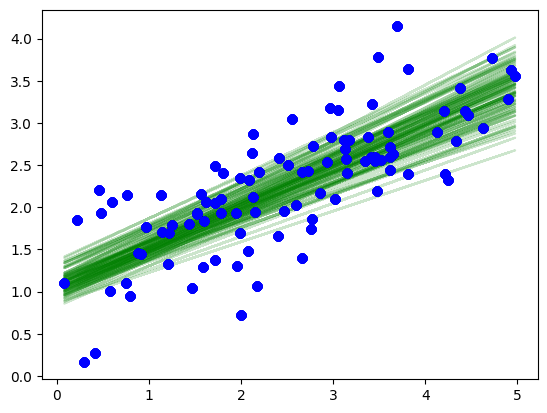

In [77]:
for _ in range(100):
    w0_mean = pyro.param("w0_mean").detach().item()
    w0_scale = pyro.param("w0_scale").detach().item()
    w1_mean = pyro.param("w1_mean").detach().item()
    w1_scale = pyro.param("w1_scale").detach().item()
    w0_sample = pyro.sample("w0_sample", dist.Normal(w0_mean, w0_scale)).numpy()
    w1_sample = pyro.sample("w1_sample", dist.Normal(w1_mean, w1_scale)).numpy()
    data_plotter(new_data, approx_w0=w0_sample, approx_w1=w1_sample)
data_plotter(new_data)
plt.show()

**Comparing the models from using a 10 instance and 100 instance dataset with same underlying true parameters:**
* Visually the models that are less spread (green lines), meaning there is more confidence in the $w_0$ and $w_1$ estimates. Thus, the scale of the posterior distributions of the parameters have become smaller.

* One reason can be; with more observations, the gradients calculated during optimization are based on a larger sample, leading to more accurate and stable estimates, which can improve the speed and reliability of convergence.

### Analyze how learning is affected by changing the learning rate and the initial values of the parameters specified in the guide function.

In [134]:
learn(data=new_data, lr=0.0001)

Loss (iter: 0): 150030.51787495613
w0: 19.472454071044922 +/- 0.6542505025863647	 	 w1: 3.497340679168701 +/- 0.00014109912444837391
Loss (iter: 100): 1791.3203395605087
w0: 14.272123336791992 +/- 0.4962409734725952	 	 w1: -3.8396105766296387 +/- 0.00014249181549530476
Loss (iter: 200): 1199.5959405899048
w0: 12.169889450073242 +/- 0.44160300493240356	 	 w1: -3.124501943588257 +/- 0.00014392679440788925
Loss (iter: 300): 894.8087968826294
w0: 10.38383960723877 +/- 0.3800903260707855	 	 w1: -2.5663270950317383 +/- 0.0001453734585084021
Loss (iter: 400): 693.4903257489204
w0: 8.891857147216797 +/- 0.3204210102558136	 	 w1: -2.058328628540039 +/- 0.0001468346599722281
Loss (iter: 500): 565.6439331769943
w0: 7.643228054046631 +/- 0.2936845123767853	 	 w1: -1.652124047279358 +/- 0.00014830532018095255
Loss (iter: 600): 449.27323269844055
w0: 6.583461284637451 +/- 0.2772485017776489	 	 w1: -1.3382058143615723 +/- 0.00014979613479226828
Loss (iter: 700): 342.8163275718689
w0: 5.70015192031860

**Experiment setup**:
The guide function is specifying the variational distribution for the parameters: 
* LR = 0.0001
* $q_{w_0}$: $\mu = 20$, $\sigma^2 = 5$
* $q_{w_1}$: $\mu = 5$, $\sigma^2 = 10$

Observations from using means further from the true posterior mean:
* Starting with a mean value that is far from the true posterior means the optimization algorithm will need to traverse a longer path to reach the area of high posterior density.
* Increased Learning Time: More iterations might be required to reach convergence, as each step of the optimization will incrementally move the estimated mean towards the true posterior mean.
* If the model has local optima or if the optimization gets stuck due to a suboptimal learning rate, the parameter estimates may converge to incorrect values.

Observations from using standard deviations further from the true posterior std:
* A greater standard deviation may make the distribution underconfident, capturing a broader range of values than is supported by the data.

Effects of Learning Rate:
* With a Smaller Learning Rate: Convergence will be slower, which can be beneficial for avoiding local optima but may require many iterations to reach the true posterior values, especially if starting far from these values.